# Imports

## Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 12]


import seaborn as sns
sns.set_style(style='ticks', rc=None)
import sklearn
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import random


from sklearn.preprocessing import OneHotEncoder

## Dataset

In [2]:
original = pd.read_csv('data/online_shoppers_intention_DATAPTDIC19.csv', sep=',', index_col=0)

In [3]:
data = original.copy()

# Functions

In [4]:
## Function to explain NA values in a column:

def NA_values(series):
    '''
    Function that takes a Pandas Series and returns a print statement explaining NAs and % of the column
    '''
    
    return print(f'Column name: {series.name}\nTotal values: {int(series.count())}\nNA values: {series.isna().sum()}\n% of NA values: {round(series.isna().mean() * 100,2)}%')

In [5]:
## Function to get the information about the outliers of a column:

def outliers_info(dataset, fillna= True, how= 'ffill'):
    """
    Function takes dataset and returns a DataFrame with information about the outliers in the numeric columns.
    It also can fill the NA values present in the dataset.
    
    Input:
        - dataset, e.g. data
        
    Output:
        - DataFrame containing information about the outliers in each column
    """
    
    if fillna:
        dataset = dataset.fillna(method= how)
        
    data= []
    for series in dataset.select_dtypes('float').columns:
        
        name = dataset[series].name
        
        Q1 = np.percentile(dataset[series], 25)
        Q3 = np.percentile(dataset[series], 75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        val_min = min(dataset[series])
        val_max = max(dataset[series])
        
        total_outliers = len(dataset.loc[(dataset[series] > upper) | (dataset[series] < lower)])
        percent_outliers = total_outliers / len(dataset) * 100
        
        data.append([name, val_min, val_max, Q1, Q3, IQR, lower, upper, total_outliers, percent_outliers])
        
    return pd.DataFrame(data, columns=['Column', 'Min Value', 'Max Value', 
                                       'Q1', 'Q3', 'IQR', 'Out_Under', 'Out_Over', 
                                       'Outliers', '% Outliers']).set_index('Column')

    ## TODO: Identify which column needs outlier treatment and which not
    ## TODO: Find a way to print outliers in the function


# EDA

## Quick look

In [6]:
data.shape

(12330, 18)

In [7]:
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1.0,1,1.0,Returning_Visitor,0.0,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2.0,1,2.0,Returning_Visitor,0.0,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1.0,9,3.0,Returning_Visitor,0.0,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2.0,2,4.0,Returning_Visitor,0.0,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3.0,1,4.0,Returning_Visitor,1.0,False


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12296 non-null float64
Administrative_Duration    12316 non-null object
Informational              12316 non-null float64
Informational_Duration     12316 non-null object
ProductRelated             12196 non-null float64
ProductRelated_Duration    12316 non-null float64
BounceRates                12216 non-null float64
ExitRates                  12316 non-null float64
PageValues                 12310 non-null object
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null object
Browser                    12230 non-null float64
Region                     12230 non-null object
TrafficType                12210 non-null float64
VisitorType                12310 non-null object
Weekend                    12310 non-null object
Revenue                    12330 non-null bool
dt

We can see that some of our numerical columns have wrong dtypes. This may be due to errors in string-form in some of the values, that force pandas to transform all the colum to object type.  By the moment, we'll be transforming this columns to numeric types, transforming all the non-numeric values to NaN in the process, to be taken care of later on.

In [9]:
object_cols = ['Month', 'VisitorType']

numerical_cols = [col for col in data.columns if col not in object_cols]

In [10]:
eda_data = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

In [11]:
outliers_info(eda_data)

,Min Value,Max Value,Q1,Q3,IQR,Out_Under,Out_Over,Outliers,% Outliers
Column,,,,,,,,,
Administrative,0.0,999.000000,0.000000,4.000000,4.000000,-6.000000,10.000000,503,4.079481
Administrative_Duration,-99.0,3398.750000,0.000000,92.287500,92.287500,-138.431250,230.718750,1175,9.529603
Informational,0.0,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2635,21.370641
Informational_Duration,-1.0,2549.375000,0.000000,0.000000,0.000000,0.000000,0.000000,2441,19.797242
ProductRelated,0.0,705.000000,7.000000,38.000000,31.000000,-39.500000,84.500000,986,7.996756
ProductRelated_Duration,-1.0,63973.522230,185.287500,1469.163556,1283.876056,-1740.526583,3394.977639,956,7.753447
BounceRates,0.0,3.000000,0.000000,0.017020,0.017020,-0.025530,0.042549,1561,12.660178
ExitRates,0.0,0.200000,0.014286,0.050000,0.035714,-0.039286,0.103571,1094,8.872668
PageValues,0.0,361.763742,0.000000,0.000000,0.000000,0.000000,0.000000,2721,22.068127


## Visual exploration

### Target column

Our target column will be `'Revenue'`, a column that indicates if the user has generated some revenue on the webpage. This column is a boolean type column, and has the following distribution:

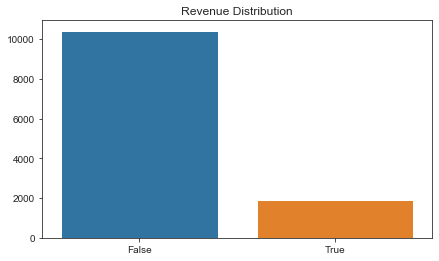

In [12]:
plt.figure(figsize=(7,4))
sns.countplot(eda_data.Revenue)
plt.title('Revenue Distribution')
plt.xlabel('')
plt.ylabel('')
# plt.savefig('Revenue_dist')
plt.show()

We can see that our values are not balanced (equal values for True and False). In order to make proper predictions with our machine learning models, we'll have to balance this later on.

### Data distribution

We'll do a quick visual exploration on each column to find potential issues on its values, and see how they are distributed compared to our target column 'Revenue'.

We'll divide our columns in categorical and continuous columns, to be able to properly observe its characteristics.

In [13]:
cat_columns = [eda_data[col].name for col in eda_data.columns if len(eda_data[col].unique()) < 30 if col != 'Revenue']

cont_columns = [eda_data[col].name for col in eda_data.columns if len(eda_data[col].unique()) > 30]


##### Categorical columns

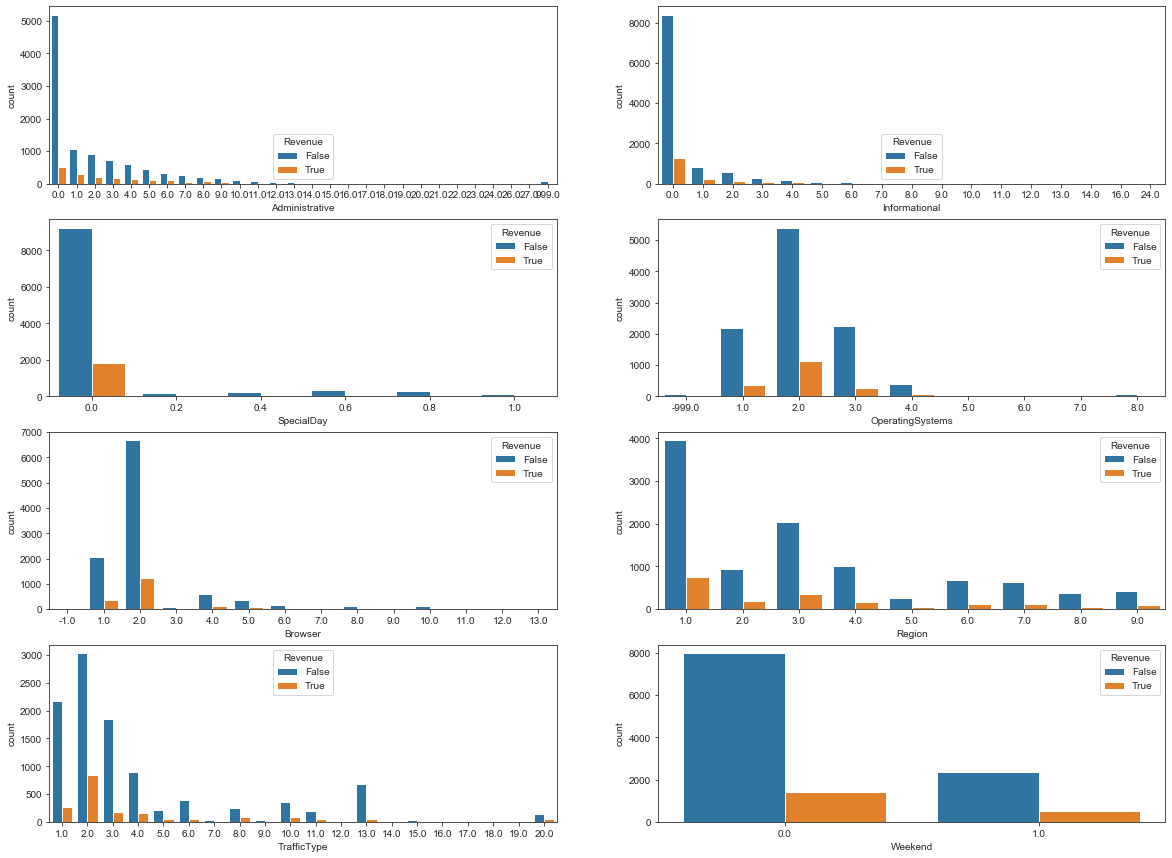

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,15))
# fig.subplots_adjust(hspace=0.5)
for ax, col in zip(axes.flatten(), cat_columns):
        sns.countplot(data=eda_data, x=col, hue='Revenue', ax=ax)

##### Continuous numeric values

In order to idenitify outliers and other irregularities, we'll using boxplots:

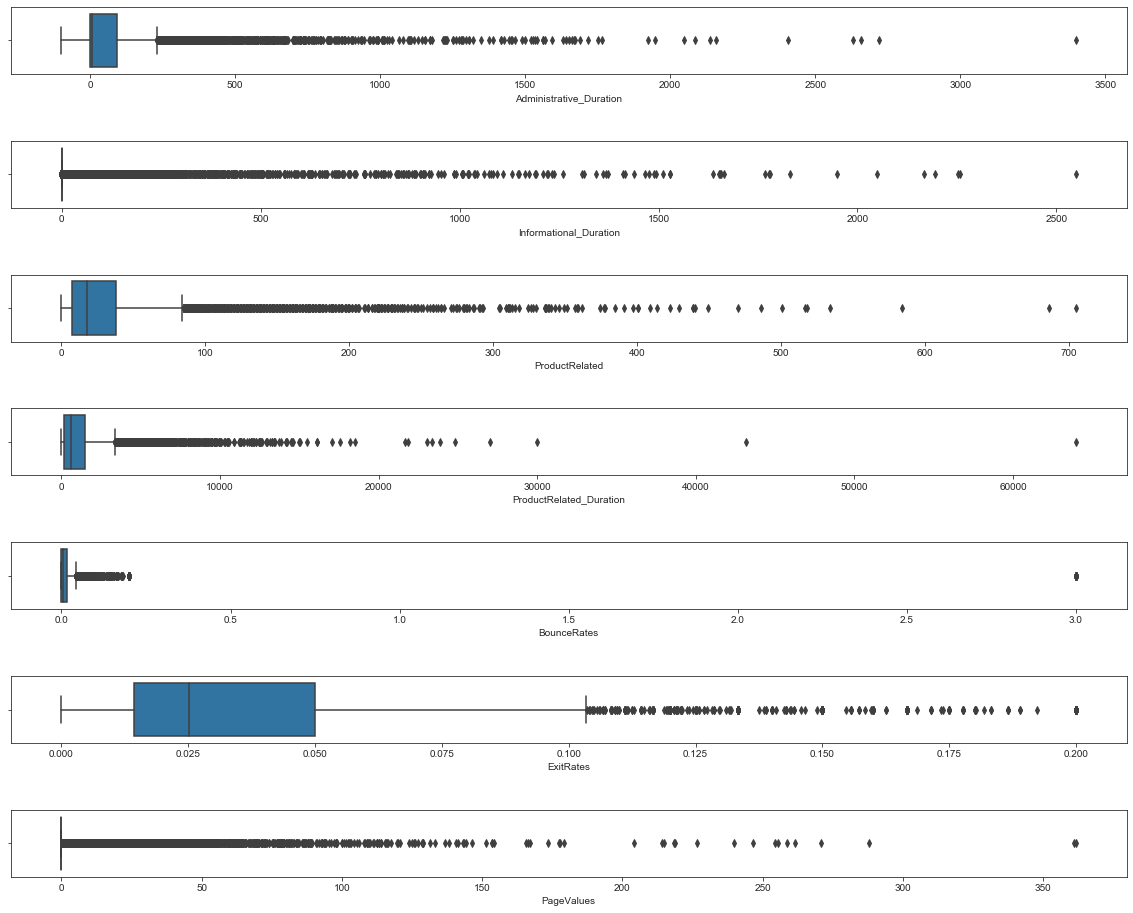

In [15]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,16))
fig.subplots_adjust(hspace=1)
for ax, col in zip(axes.flatten(), cont_columns):
    sns.boxplot(eda_data[col], orient='h', ax=ax)
#     plt.title(col)
#     sns.swarmplot(data['Revenue'], ax=ax)

### Correlation

In order to analyze similarities between columns, we're looking for correlations. We're seeting up a function to be able to identify them in a clearer way:

In [16]:
def correlation_heatmap(dataframe):
    '''
    This function takes a dataframe as input and draws a heatmap with its correlations
    '''

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(dataframe.corr(), dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(dataframe.corr(), mask=mask, cmap=cmap, vmax=.9, center=0,
                square=True, linewidths=.5, annot = True, cbar_kws={"shrink": .5})

    plt.show()

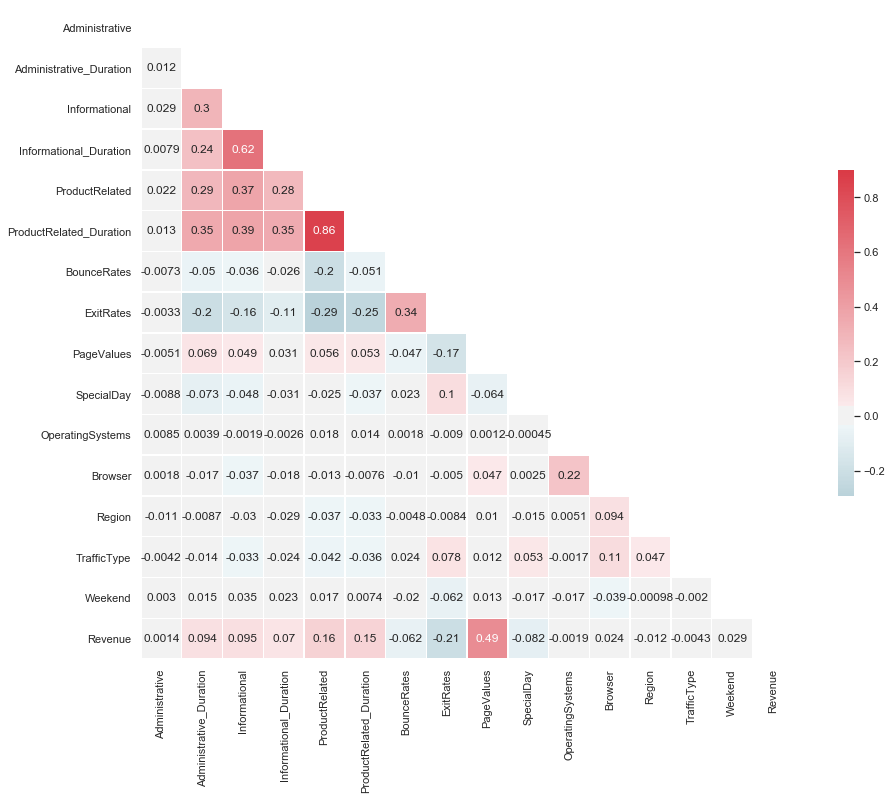

In [17]:
correlation_heatmap(eda_data)

In this heatmap, we can see mild correlations in the dataset overall. The most relevant ones are:

- `Informational` and `Informational_Duration`: This is logical, the many pages you visited, the more time you spend on them. Not really relevant.

- `ProductRelated` and `ProductRelated_Duration`: Same happens in this case, but with Product related webpages
- `BounceRates` and `Exit_Rates`: This is also logical, since everytime a user quits the page without entering another section, is exiting the page at some point.
- `PageValues` and `Revenue`: This is a biased correlation. The PageValues metric indicates the average value for a page that a user visited before landing on the goal page or completing an Ecommerce transaction. So, we'll have to remove this column since we have this metric AFTER a client has generated revenue.

## EDA Insights and planning

This dataset gathers information about costumers visiting an e-commerce webpage during a month. We'll be inspecting this data in order to be able to achieve our objective: being able to predict if a customer is likely to generate revenue given the dataset information.

This data does not come in a clean way, so after we inspected it we found that we'll have to fix some issues on the following columns:

- **Administrative:** 
    - Number of pages type Administrative that the customer visited.
        - Contains some 999.0 values. This is a lecture error, so we'll transform this values to `NaN`
    
    
- **Administrative_Duration:** 
    - Duration of the overall sessions in this type Administrative pages.
        - `object` type column. Since the data is numerical, we'll change it to `float`
        - Again, we'll move -99 and -1.0 values to `NaN` 
    
    
- **Informational**: 
    - Number of pages type Informational that the customer visited.
        - Column type `float`. No processing needed. 


- **Informational_Duration:** 
    - Duration of the overall sessions in this type Informational pages
        - Column type `object`. We're changing `object` type to `float`
        - change -1.0 to nan
        - change None to nan
    
- **ProductRelated**: 
    - Number of pages related to a single product that the customer has visited. 

- **ProductRelated_Duration:** 
    - Duration of the overall sessions in this product pages
        - change -1.0 values to Nan

- **Page Values**: 
    - Average value for a page that a user visited before landing on the goal page or completing an Ecommerce transaction.
        - change `object` type to `float`
        - #Nan change to `NaN`
    
- **BounceRates:** 
    - Bounce Rates of a web page. Percentages. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
    
- **ExitRates**: 
    - Exit rate of a web page. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session.
    
- **PageValues**: 
    - Page values of each web page. The "Page Value" feature represents the average value for a web page that a user visited before completing an e-commerce transaction.
   
- **SpecialDay**
    - Special days like valentine etc. Closeness to a special date. For example, for Valentina’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 
 
- **Month**: 
    - Month of the year.
        - change 'MAY' to May and 'March' to Mar
    
- **OperatingSystems**: 
    - Operating system used.
        - change -999 and ? to `NaN`
    
- **Browser**: 
    - Browser used.
        - change -1 to `NaN` or it's a separate category of a browser?
    
- **Region**: 
    - Region of the user.
        - change 'Nan' to `NaN`
    
- **TrafficType** 
     - Origin of the visit. It can be Direct, Organic, Paid, Referral or Social Media.  

- **VisitorType**: 
    - Indicates if a costumer returned to the page or not.
        - unify 'more' to other or change both to `NaN`?
    
- **Weekend**
    - Indicates if the user entered the wabpage on weekend
        - change `object` type to `bool`
        - change weekdays to 0 and 1
    
- **Revenue**: 
    - Indicates if a client generated income or not
       
    
 
  

 



# Data cleaning

## Values correction

Following the instructions explained on the previous step, we proceed to clean the DataFrame. We will also save this Dataframe as an unprocessed but clean one.

In [18]:
data.Administrative = data.Administrative.replace(999.0, np.nan)
data.Administrative_Duration = data.Administrative_Duration.replace(['-1.0', '-99'], np.nan)
data.Informational_Duration = data.Informational_Duration.replace(['-1.0', 'None'], np.nan)
data.ProductRelated_Duration = data.ProductRelated_Duration.replace(-1.000000, np.nan)
data.PageValues = data.PageValues.replace('#Nan', np.nan)
data.Month = data.Month.str.replace('MAY', 'May').str.replace('March', 'Mar')
data.OperatingSystems = data.OperatingSystems.replace(['-999', '?'], np.nan)
data.Browser = data.Browser.replace(-1.0, np.nan)
data.Region = data.Region.replace('Nan', np.nan)
data.VisitorType = data.VisitorType.str.replace('More', 'Other').replace('Other', np.nan)
data.Weekend = data.Weekend.replace({'Tuesday' : '0.0', 'Monday': '0.0', 'Friday': '0.0', 'Sunday': '1.0'})

## Dtypes correction

Some columns had wrong data types due to pandas import. Some columns had string character on numeric columns so they were converted to object. We're fixing this:

In [19]:
to_object = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 
             'Weekend', 'Revenue']

to_float = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 
            'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

data[to_object] = data[to_object].astype('object')

data[to_float] = data[to_float].apply(pd.to_numeric, errors='coerce')

## NA Treatment

Due to the distribution of the NaN values, we decided to fill them with Forward Fill. This allows us to preserve some data without affecting the distribution of it.

In [20]:
clean_no_nan = data.fillna(method='ffill').copy()

In [21]:
clean_no_nan.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Exporting

In [22]:
# clean_no_nan.to_csv('Onlineshop_clean.csv')

# Data Transformation

Since we're performing some Machine Learning algorithms on our data, there are some transformations we need to do in order to be able to train our models.

## Transforming columns

Adding a column from VisitorType transforming it's content into boolean: 1 is_returning, 0 is_new


In [23]:
clean_no_nan['Visitor_isReturning'] = clean_no_nan['VisitorType'].replace('Returning_Visitor', 1).replace('New_Visitor', 0)

## One Hot Encoding

We'll also taking categorical variables and applying One Hot Encoding as a method of encoding for the models to work properly. We're applying this method to three columns: 'Month', 'OperatingSystems' and 'Region'.

In [24]:
appended_dfs = []

columns = ['Month', 'OperatingSystems', 'Region']

for col in columns:
    # Creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # Passing columns
    enc_df = pd.DataFrame(enc.fit_transform(clean_no_nan[[col]]).toarray())
    # Getting values for the names of the columns
    enc_df.columns = enc.get_feature_names()+col
    # Appenign all new dfs to one list
    appended_dfs.append(enc_df)
# mergeing with main df
df_encoded = clean_no_nan.join(appended_dfs) 

## Random Column

A good technique for evaluating performance is generating a random values column. We're inserting random value column as measure of feature importance. If a feature has less score that this random generated column, it's a sign of its poor significance in our data.

In [25]:
rand = [random.random() for i in range(len(df_encoded))]

df_encoded['random'] = rand

We've finished with the preparation of our data. It's now prepared for all the steps needed for predicting values with machine learning, so we'll also save a copy of this dataframe as encoded:

In [26]:
# df_encoded.to_csv('OnlineShop_encoded.csv')